In [225]:
import numpy as np
import matplotlib.pyplot as plt

## Windy Gridworld

**Problem**: re-solve the windy gridworld assuming eight possible actions, including the diagonal moves, rather than four. How much better can you do with the extra actions? Can you do even better by including a ninth action that causes no movement at all other than that caused by the wind?

First step would be to implement the base case and see if the result is similar to what is shown in the textbook

### Example 6.5 Windy Gridworld

Reach the goal from starting point. **Undiscounted** task with constant -1 rewards per time step until goal is reached.

Action space: [`up`, `down`, `left`,`right`]

State space: gridworld

In the middle region there is an upwind wind that causes next states to be shifted upwards. The strength varies from column to column.

Implement e-greedy SARSA. Consider $\epsilon = 0.1$ and $\alpha = 0.5$ and initial action-state values at 0. 

In [291]:
import numpy as np
import math

def create_grid(n_rows:int, n_columns:int) -> np.ndarray:
    return np.zeros((n_rows, n_columns), dtype = np.uint8)

class WindyGridWorld:
    """
    Action is in the form [left, up, right, down]
    """

    def __init__(self, rows, columns, wind_col_range):
        self.rows = rows
        self.columns = columns
        self.last_state = None
        self.wind_col_range = wind_col_range
        self.max_wind_magnitude = 2
        self.wind_magnitudes = self._setup_wind_magnitudes(wind_col_range)
        self.goal = (rows//2, int(columns*3/4))
        self.path_x, self.path_y = [], []
        self.reset()

    def _set_initial_state(self) -> tuple[int, int]:
        return self.rows // 2, 0
    
    def _check_if_wind_affected(self, column: int)-> bool:
        pos_rel_to_wind = column - self.wind_col_range[0]
        if pos_rel_to_wind < 0 :
            return False
        if pos_rel_to_wind < self.wind_col_range[1] - self.wind_col_range[0]:
            return True
        return False

    
    def _compute_new_state(self, state: tuple[int, int], action: tuple[bool, bool, bool, bool]) -> tuple[int, int]:
        assert np.sum(action) == 1, "Multiple direction displacements not permited"
        left, up, right, down = action
        new_row = state[0] - up + down
        new_col = state[1] - left + right
        # upwind affects rows
        if (self._check_if_wind_affected(new_col)):
            new_row = new_row - self.wind_magnitudes["wind_values"][new_col - self.wind_col_range[0]]
        new_row = max(0,min(new_row, self.rows-1))
        new_col = max(0,min(new_col, self.columns-1))
        return new_row, new_col


    def _check_termination(self, new_row, new_col) -> bool:
        return new_row == self.goal[0] and new_col == self.goal[1]

    
    def _setup_wind_magnitudes(self, windy_col_range: tuple[int, int]) -> dict[str, tuple[int]]:
        min_col, max_col = windy_col_range
        affected_cols = [c for c in range(min_col, max_col)]
        wind_magnitudes = [min(i+1, self.max_wind_magnitude) for i in range(math.ceil((max_col-min_col) / 2))]
        wind_magnitudes += wind_magnitudes[-1-(max_col-min_col)%2::-1]
        return {"columns":affected_cols,"wind_values":wind_magnitudes}

    def _update_grid_trayectory(self):
        self.path_y.append(self.last_state[0])
        self.path_x.append(self.last_state[1])
        self.grid[*self.last_state] = 1

    def plot_trayectory(self):
        for col in self.wind_magnitudes['columns']:
            plt.annotate("", xytext=(col, self.rows-1), xy=(col, 0),
            arrowprops=dict(arrowstyle="->"))
        plt.annotate("X",xy=self.goal[::-1], color='red')
        plt.plot(self.path_x, self.path_y, color='blue')
        plt.imshow(self.grid, cmap='Accent')
        plt.title("WindyGridWorld Trajectory")
        plt.show()

    def reset(self):
        self.grid = create_grid(self.rows, self.columns)
        self.path_x, self.path_y = [], []
        self.last_state = self._set_initial_state()
        self._update_grid_trayectory()
        return self.last_state

    def step(self, action: tuple[bool, bool, bool, bool]) -> tuple[tuple[int, int], int, bool]:
        """
        return state, reward, done
        """
        new_row, new_col = self._compute_new_state(self.last_state, action)
        self.last_state = (new_row, new_col)
        self._update_grid_trayectory()
        if self._check_termination(new_row, new_col):
            return self.last_state, 0, True
        return (new_row, new_col), -1, False

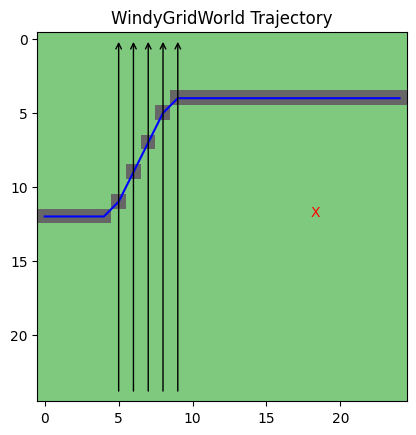

In [292]:
gridworld = WindyGridWorld(25,25,(5,10))
for i in range(25):
    gridworld.step((0,0,1,0))
gridworld.plot_trayectory()

## QFunction

In [293]:
def build_state_key(state: tuple[int, int]) -> str:
  return f"{state[0]}_{state[1]}"

def init_action_space():
  return [
        (1,0,0,0),
        (0,1,0,0),
        (0,0,1,0),
        (0,0,0,1)
  ]

def init_actions_for_state(state: tuple[int,int],  actions: list[tuple[bool]]) -> list[tuple[bool]]:
    return actions

class QFunction:
  """
  Q value function for state
  """
  def __init__(self, action_space: list[tuple[bool, bool, bool, bool]]):
    self.values = {}
    self.action_space = action_space

  def _init_q_values(self, state):
    valid_actions = init_actions_for_state(state, self.action_space)
    action_values = [0 for _ in valid_actions]

    self.values[build_state_key(state)] = {
        "actions":valid_actions,
        "values":action_values
    }

  def _get_action_id(self, actions, action):
    for id, act in enumerate(actions):
      same = sum([v1*v2 for (v1,v2) in zip(act,action)])
      if same == 1:
        return id
      
  def get_actions(self, state) -> list:
    return self.values[build_state_key(state)]["actions"]


  def get_max_action(self, state):
    s_key = build_state_key(state)
    if s_key not in self.values:
      self._init_q_values(state)
    actions = self.values[s_key]["actions"]
    action_values = self.values[s_key]["values"]
    return actions[np.argmax(action_values)]

  def get_value(self, state, action):
    s_key = build_state_key(state)
    if s_key not in self.values:
      self._init_q_values(state)
    act_id = self._get_action_id(self.values[s_key]["actions"], action)
    if act_id is None:
      raise ValueError(f"No action: {action} registered for state: {state}")
    return self.values[s_key]["values"][act_id]

  def update(self, state, action, new_value):
    s_key = build_state_key(state)
    if s_key not in self.values:
      self._init_q_values(state)
    action_id = self._get_action_id(self.values[s_key]["actions"],action)
    if action_id is None:
      raise ValueError(f"No action: {action} is recorded for state: {state}")
    self.values[s_key]["values"][action_id] = new_value


In [294]:
test_q = QFunction(init_action_space())
test_q.get_max_action((3,0))

(1, 0, 0, 0)

In [295]:
import random

def e_greedy_from_q(q:QFunction, state, epsilon):
    action = q.get_max_action(state)
    if random.random() <= epsilon:
        actions = q.get_actions(state)
        return random.choice(actions)
    return action

In [300]:
from tqdm import tqdm

ALPHA = 0.5
N_EPISODES = 10000
EPSILON = 0.1
GAMMA = 1

q_func = QFunction(init_action_space())
windy_env = WindyGridWorld(30,30,(3,8))
for i in tqdm(range(N_EPISODES)):
    windy_env.reset()
    while True:
        s = windy_env.last_state
        a = e_greedy_from_q(q_func, s, EPSILON)
        s_p,r, terminate = windy_env.step(a)
        if terminate:
            break
        a_p = e_greedy_from_q(q_func, s_p, EPSILON)
        new_q = q_func.get_value(s,a) + ALPHA*(r + 1*q_func.get_value(s_p, a_p) - q_func.get_value(s,a))
        q_func.update(s, a, new_q)

100%|██████████| 10000/10000 [00:04<00:00, 2108.27it/s]


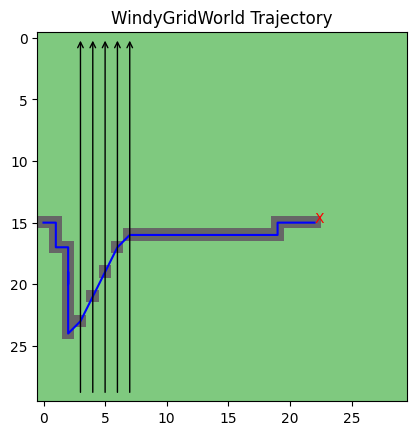

In [301]:
windy_env.plot_trayectory()